In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [ ]:
TRAIN_PATH = "train.csv"   
TEST_PATH = "test.csv"     # optional; we will use a held-out split from train.csv
NROWS = 5000               # start out with less!
RANDOM_SEED = 42
PRIMARY_LABEL = "toxic"    # which label column to use for the binary classification task -- seemed relevant
TFIDF_MAX_FEATURES = 5000

# Load dataset
train_df = pd.read_csv(TRAIN_PATH, nrows=NROWS, header=0, index_col="id")
print("Loaded train_df shape:", train_df.shape)
print(train_df.columns)

# Quick dataset description for the report
print("Label distribution (counts):")
print(train_df[PRIMARY_LABEL].value_counts())

# Preprocess features & labels
# Remove rows with missing comment_text
train_df = train_df.dropna(subset=["comment_text"])
X_raw = train_df["comment_text"].astype(str)
y = train_df[PRIMARY_LABEL].astype(int)

# Train/test split
# Use stratified split to keep class balance
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)


KNN | Acc: 0.932 | F1: 0.547 | Prec: 0.837 | Rec: 0.406

Classification report:
              precision    recall  f1-score   support

   Non-toxic       0.94      0.99      0.96       899
       Toxic       0.84      0.41      0.55       101

    accuracy                           0.93      1000
   macro avg       0.89      0.70      0.75      1000
weighted avg       0.93      0.93      0.92      1000



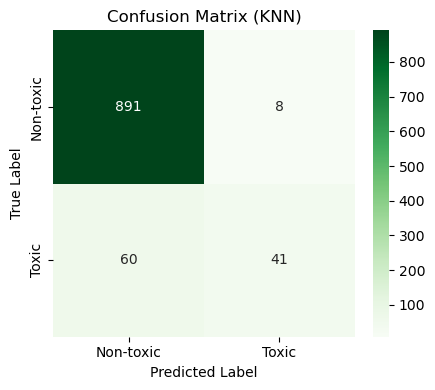

In [4]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=TFIDF_MAX_FEATURES)
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

# Models we tried! 
#model_name = "Logistic Regression"
#clf = LogisticRegression(max_iter=200, solver="liblinear", random_state=RANDOM_SEED)

#model_name = "Naive Bayes"
#clf = MultinomialNB()

## ✨Chosen One✨ ## 
model_name = "KNN"
clf = KNeighborsClassifier(n_neighbors=5, metric="cosine", n_jobs=-1)

# Training model
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, zero_division=0)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)

# Results summary
print(f"\n{model_name} | Acc: {acc:.3f} | F1: {f1:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["Non-toxic", "Toxic"], zero_division=0))

# Conf Matrix 
plt.figure(figsize=(4.5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d",
            cmap="Greens" if model_name == "KNN" else "Blues",
            xticklabels=["Non-toxic", "Toxic"], yticklabels=["Non-toxic", "Toxic"])
plt.title(f"Confusion Matrix ({model_name})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


Done LOO for idx=2805: influence=-0.003669 (V(D\{i})=0.5503)
Done LOO for idx=2706: influence=0.000000 (V(D\{i})=0.5467)
Done LOO for idx=299: influence=0.000000 (V(D\{i})=0.5467)
Done LOO for idx=2004: influence=0.000000 (V(D\{i})=0.5467)
Done LOO for idx=834: influence=0.000000 (V(D\{i})=0.5467)
Done LOO for idx=3997: influence=0.000000 (V(D\{i})=0.5467)
Done LOO for idx=1975: influence=0.000000 (V(D\{i})=0.5467)
Done LOO for idx=2589: influence=0.000000 (V(D\{i})=0.5467)
Done LOO for idx=3895: influence=0.000000 (V(D\{i})=0.5467)
Done LOO for idx=1346: influence=0.000000 (V(D\{i})=0.5467)
   train_index  removed_label  influence
0         2706              1   0.000000
1          299              1   0.000000
2         2004              1   0.000000
3          834              1   0.000000
4         3997              0   0.000000
5         1975              0   0.000000
6         2589              0   0.000000
7         3895              0   0.000000
8         1346              0   

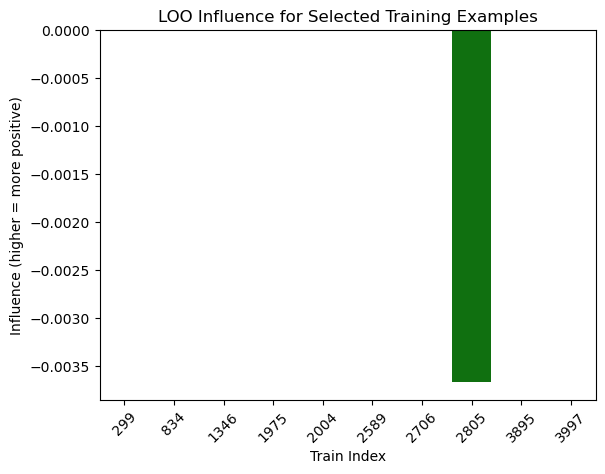

In [5]:
# Part 2 - Brute-force LOO Influence
from scipy.sparse import csr_matrix
from sklearn.neighbors import KNeighborsClassifier

V_D = f1  # F1 (Part 1)

# selected 10 training indices (5 toxic + 5 non-toxic)
train_indices = list(range(X_train.shape[0]))
rng = np.random.RandomState(RANDOM_SEED)
train_labels_array = np.array(y_train)
pos_idx = np.where(train_labels_array == 1)[0].tolist()
neg_idx = np.where(train_labels_array == 0)[0].tolist()

selected_indices = []
n_per_class = 5
if len(pos_idx) >= n_per_class and len(neg_idx) >= n_per_class:
    selected_indices += list(rng.choice(pos_idx, size=n_per_class, replace=False))
    selected_indices += list(rng.choice(neg_idx, size=n_per_class, replace=False))
else:
    selected_indices = list(rng.choice(train_indices, size=10, replace=False))

results = []

X_train_csr = csr_matrix(X_train)

# LOO
for idx in selected_indices:
    mask = np.ones(X_train_csr.shape[0], dtype=bool)
    mask[idx] = False

    X_lo = X_train_csr[mask]
    y_lo = np.array(y_train)[mask]

    # KNN classifier recreated (same parameters as baseline)
    clf_lo = KNeighborsClassifier(n_neighbors=5, metric="cosine", n_jobs=-1)
    clf_lo.fit(X_lo, y_lo)

    y_pred_lo = clf_lo.predict(X_test)
    V_D_minus_i = f1_score(y_test, y_pred_lo, zero_division=0)
    influence = V_D - V_D_minus_i

    removed_text = X_train_raw.reset_index(drop=True).iloc[idx]
    removed_label = int(np.array(y_train)[idx])

    results.append({
        "train_index": idx,
        "removed_label": removed_label,
        "influence": influence,
        "V_D_minus_i": V_D_minus_i,
        "removed_text_snippet": (removed_text[:200] + "...") if len(removed_text) > 200 else removed_text
    })

    print(f"Done LOO for idx={idx}: influence={influence:.6f} (V(D\\{{i}})={V_D_minus_i:.4f})")

# Results summary
res_df = pd.DataFrame(results).sort_values(by="influence", ascending=False).reset_index(drop=True)

# Table of results
print(res_df[["train_index", "removed_label", "influence"]])

# bar chart
sns.barplot(x="train_index", y="influence", data=res_df, color="green")
plt.title("LOO Influence for Selected Training Examples")
plt.xlabel("Train Index")
plt.ylabel("Influence (higher = more positive)")
plt.xticks(rotation=45)
plt.show()


Baseline F1-toxic V(D): 0.5467

Group-level influence scores:
   percent_removed  group_size  f1_without_group  influence
0                1          40          0.550336  -0.003669
1                2          80          0.546667   0.000000
2                5         200          0.530612   0.016054
3               10         400          0.556291  -0.009625
4               15         600          0.527778   0.018889
5               20         800          0.563758  -0.017092
6               25        1000          0.543046   0.003620
7               30        1200          0.520000   0.026667
8               40        1600          0.500000   0.046667
9               50        2000          0.533333   0.013333


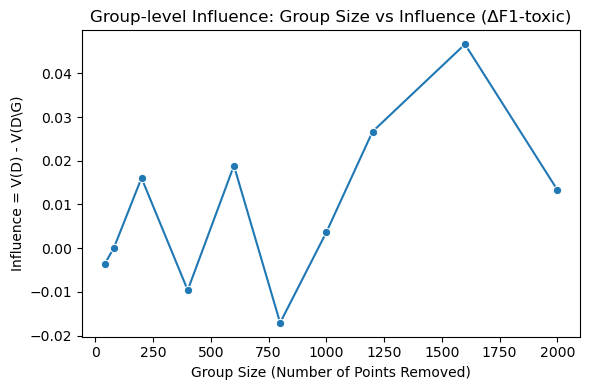

In [6]:
# Part 3 - Group-level Influence
from sklearn.neighbors import KNeighborsClassifier

print("Baseline F1-toxic V(D):", round(V_D, 4))

# Randomly select 10 groups of different sizes
percent_list = [1, 2, 5, 10, 15, 20, 25, 30, 40, 50]

rng = np.random.RandomState(RANDOM_SEED)
y_train_arr = np.array(y_train)
n_train = X_train.shape[0]

results = []

for p in percent_list:
    group_size = int(np.ceil(n_train * (p / 100.0)))
    indices = rng.choice(n_train, size=group_size, replace=False)

    # Remove selected group
    mask = np.ones(n_train, dtype=bool)
    mask[indices] = False
    X_train_new = X_train[mask]
    y_train_new = y_train_arr[mask]

    # Retrain KNN model
    knn = KNeighborsClassifier(n_neighbors=5, metric="cosine", n_jobs=-1)
    knn.fit(X_train_new, y_train_new)

    # Compute influence
    y_pred = knn.predict(X_test)
    f1_new = f1_score(y_test, y_pred, zero_division=0)
    influence = V_D - f1_new

    results.append({
        "percent_removed": p,
        "group_size": group_size,
        "f1_without_group": f1_new,
        "influence": influence
    })

group_df = pd.DataFrame(results)
print("\nGroup-level influence scores:")
print(group_df)

# Plot
plt.figure(figsize=(6, 4))
sns.lineplot(data=group_df, x="group_size", y="influence", marker="o")
plt.title("Group-level Influence: Group Size vs Influence (ΔF1-toxic)")
plt.xlabel("Group Size (Number of Points Removed)")
plt.ylabel("Influence = V(D) - V(D\\G)")
plt.tight_layout()
plt.show()

Permutation 1/10 done (final perf=0.1835) Permutation = [ 834 2706 2004 1346]
Permutation 2/10 done (final perf=0.1835) Permutation = [2805 3895 1975  834  299]
Permutation 3/10 done (final perf=0.1835) Permutation = [ 834 2004]
Permutation 4/10 done (final perf=0.0000) Permutation = [2589 1975  299 3895 2805]
Permutation 5/10 done (final perf=0.2428) Permutation = [2805 3997 2589 1975  834  299 1346 3895 2004 2706]
Permutation 6/10 done (final perf=0.0000) Permutation = [2805 3895 3997 2589 1975 2004]
Permutation 7/10 done (final perf=0.2533) Permutation = [2805 2004 3895 3997 1346  834 2589 2706  299]
Permutation 8/10 done (final perf=0.0000) Permutation = [3895 1975 2589 3997]
Permutation 9/10 done (final perf=0.2156) Permutation = [2706  299 2004 2805 3895 2589 1975  834]
Permutation 10/10 done (final perf=0.2348) Permutation = [ 834 3997 2589 1975 2706 2805  299 3895 1346 2004]


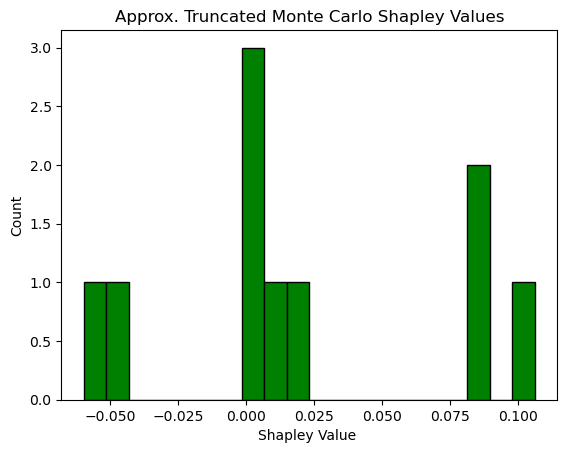

In [7]:
# Part 4 Shapley Value

# For each observation and each group:
#  - compute the Shapley value using Truncated Monte Carlo Shapley Value Estimation
# 
# Truncated Monte Carlo Shapley Value Estimation

def get_X_and_Y(selected_indices):
    
    for idx in selected_indices:
        mask = np.zeros(X_train_csr.shape[0], dtype=bool)
        mask[idx] = True
    
        Y_selected = np.array(y_train)[mask]
        X_selected=X_train_csr[mask]
        
    return X_selected, Y_selected

def get_permutation(all_data):
    #llo_dataframe=pd.DataFrame(all_data)
    #llo_dataframe["targets"] = y
    random_group_size= random.randint(2, len(all_data))
    
    rand_perm=(rng.choice(all_data,replace=False, size=random_group_size))
    X,Y=get_X_and_Y(rand_perm)
    return X,Y, rand_perm

def score_performance(y_test, y_pred): # NOTE: CHANGE THIS depending on our dataset --> Idea: use as dependancy injection!
    return f1_score(y_test, y_pred, zero_division=0)

def monte_carlo_shapley(selected_indices):
    performance_tolerance = 0.001
    previous_perms = []
    shapley_values = [0 for _ in selected_indices] 
    t = 0
    v_empty = 0.0  # baseline performance for empty model

    for current_perm in range(10):  # 10 permutations
        t = t + 1
        X_selected, y_selected, perm = get_permutation(selected_indices)
        v_prev = v_empty  # track previous coalition value

        for j, idx in enumerate(perm):
            k_val = min(5, len(perm[:j + 1]))
            clf_shap = KNeighborsClassifier(n_neighbors=k_val, metric="cosine", n_jobs=-1)
            clf_shap.fit(X_train_csr[perm[:j + 1]], np.array(y_train)[perm[:j + 1]])
            y_pred = clf_shap.predict(X_test)
            perf_score = score_performance(y_test, y_pred)

            # stop if close to full-data performance
            if abs(V_D - v_prev) < performance_tolerance:
                perf_score=v_prev     
                print(f"Truncating early at j={j}, perf={perf_score:.4f}")
                break

            marginal = perf_score - v_prev
            pos = np.where(selected_indices == idx)[0][0]
            shapley_values[pos] = ((t - 1) / t) * shapley_values[pos] + (1 / t) * marginal
            v_prev = perf_score

        previous_perms.append(perm)
        print(f"Permutation {t}/10 done (final perf={v_prev:.4f}) Permutation = {perm}")

    return shapley_values

selected_indices = np.array(selected_indices)
llo_shapley = monte_carlo_shapley(selected_indices)

plt.hist(llo_shapley, bins=20, color="green", edgecolor="black")
plt.title("Approx. Truncated Monte Carlo Shapley Values")
plt.xlabel("Shapley Value ")
plt.ylabel("Count")
plt.show()
